## Analysis and predictions

Now that I have the data, let's see if we can use it to make prediction about car pricing at current market conditions

In [421]:
import pandas as pd
import numpy as np
import Database as db
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from IPython.display import display

connection = db.create_server_connection("localhost", "root", "Englezu1992!", "CarData_BMW")

df = pd.read_sql('SELECT * FROM BMW', con=connection)

df.head()

Connection to database CarData_BMW established.


,id,price,model,year,body,milage,engine_size,engine_power,transmission,fuel_type,owners,ultra_low_emissions_zone,service_history,first_year_road_tax,full_manufacturer_warranty,unexpected_value
0,1,9995,5 Series,2015,saloon,126000,2.0,190,automatic,diesel,1,1,full dealership history,0,0,ok
1,2,14450,5 Series,2016,saloon,52761,2.0,190,automatic,diesel,100,1,unlisted,0,0,ok
2,3,11880,5 Series,2015,saloon,75000,2.0,190,automatic,diesel,100,1,unlisted,0,0,ok
3,4,10950,5 Series,2015,saloon,81000,2.0,190,automatic,diesel,3,1,unlisted,0,0,ok
4,5,13495,5 Series,2015,saloon,54758,2.0,190,automatic,diesel,2,1,full dealership history,0,0,ok


We start by having a look at our prices and we immediately find that someone has mistyped the offer price on their add. Whops.

In [422]:
display(df.loc[df['price'] == df['price'].max()])
wrong_price_index = df.index[df['price'] == df['price'].max()][0]
print(df.loc[wrong_price_index])
df.loc[wrong_price_index,'price'] = int(df['price'].max()/10)
display(df.loc[df['price'] == df['price'].max()])

,id,price,model,year,body,milage,engine_size,engine_power,transmission,fuel_type,owners,ultra_low_emissions_zone,service_history,first_year_road_tax,full_manufacturer_warranty,unexpected_value
11951,11952,511380,X3,0,suv,1000000,50.0,1000000,automatic,petrol,100,0,unlisted,1,1,ok


id                                11952
price                            511380
model                                X3
year                                  0
body                                suv
milage                          1000000
engine_size                        50.0
engine_power                    1000000
transmission                  automatic
fuel_type                        petrol
owners                              100
ultra_low_emissions_zone              0
service_history                unlisted
first_year_road_tax                   1
full_manufacturer_warranty            1
unexpected_value                     ok
Name: 11951, dtype: object


,id,price,model,year,body,milage,engine_size,engine_power,transmission,fuel_type,owners,ultra_low_emissions_zone,service_history,first_year_road_tax,full_manufacturer_warranty,unexpected_value
7244,7245,148500,X7,2021,suv,100,4.4,1000000,automatic,petrol,100,0,unlisted,0,0,ok


Next I want to correct a small oversight. I should have had the scraper identify new cars and put better values for milage and year and owners. But that's fine. We can easily identify new cars here and modify the data.

In [423]:
for idx, row in df.iterrows():
    if df.loc[idx,'year'] == 0:
        df.loc[idx,'milage'] = 0
        df.loc[idx,'year'] = 2022
        df.loc[idx,'owners'] = 0

df.loc[df['year'] ==  2022].shape

(2149, 16)

Now let's make sure that my instructions produced the right outcome.

In [424]:
print(df['milage'].describe())
print(df['year'].describe())

count      24132.000000
mean       29083.755097
std        31060.666139
min            0.000000
25%         8802.500000
50%        24018.000000
75%        41798.500000
max      1000000.000000
Name: milage, dtype: float64
count    24132.000000
mean      2017.935811
std          2.009236
min       2015.000000
25%       2016.000000
50%       2018.000000
75%       2019.000000
max       2022.000000
Name: year, dtype: float64


 We can see that there are still some cars with 1,000,000 milage however those are adds where the sellers did not care to input the car milage. I will drop them because they will confuse my prediction models. There are only 8 adds anyway.

In [425]:
print(df.shape)
df = df.loc[df['milage'] != 1000000]
print(df.shape)
print(df['milage'].describe())
df.loc[df['milage'] > 300000]

(24132, 16)
(24124, 16)
count     24124.000000
mean      28761.779887
std       25541.286902
min           0.000000
25%        8799.250000
50%       24013.000000
75%       41770.250000
max      710344.000000
Name: milage, dtype: float64


,id,price,model,year,body,milage,engine_size,engine_power,transmission,fuel_type,owners,ultra_low_emissions_zone,service_history,first_year_road_tax,full_manufacturer_warranty,unexpected_value
2650,2651,17495,3 Series,2017,saloon,512231,2.0,252,automatic,petrol plug-in hybrid,100,1,unlisted,0,0,ok
4048,4049,13940,3 Series,2017,estate,710344,1.5,136,automatic,petrol,100,1,full service history,0,0,ok


There is still see some weirdness. There are two chaps who are claiming that in 3.5 years they have done 512,231 and 710,344 miles. This is highly unlikely as that would mean they would have to spend every working day in the year, at 70 MPH for 8 hours and 11 hours respectively. This is highly improbable so I will delete this data. There are only two data points so the effect on my dataset is inconsequential.

In [426]:
print(df.shape)
df = df.loc[df['milage'] < 300000]
print(df.shape)

(24124, 16)
(24122, 16)


To warm ourselves into the analysis have a look at a quick overview of the 3 factors we are interested in, to check the health of our data.

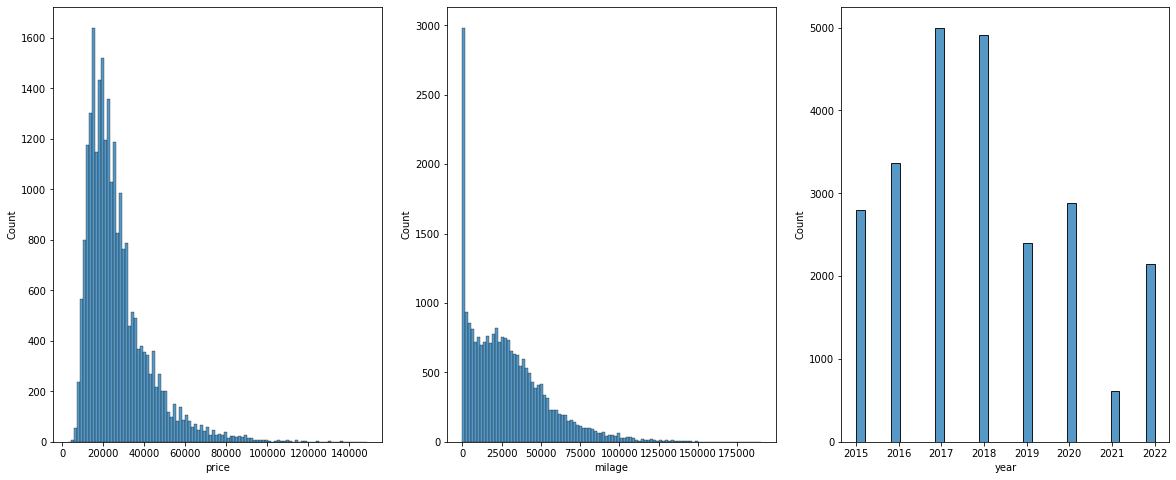

In [427]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
sns.histplot(df['price'],ax = axes[0],kde = False, bins = 100)
sns.histplot(df['milage'],ax = axes[1],kde = False, bins = 100)
sns.histplot(df['year'],ax = axes[2]);

For my own curiosity I want to check what the volumes look like for the different car models

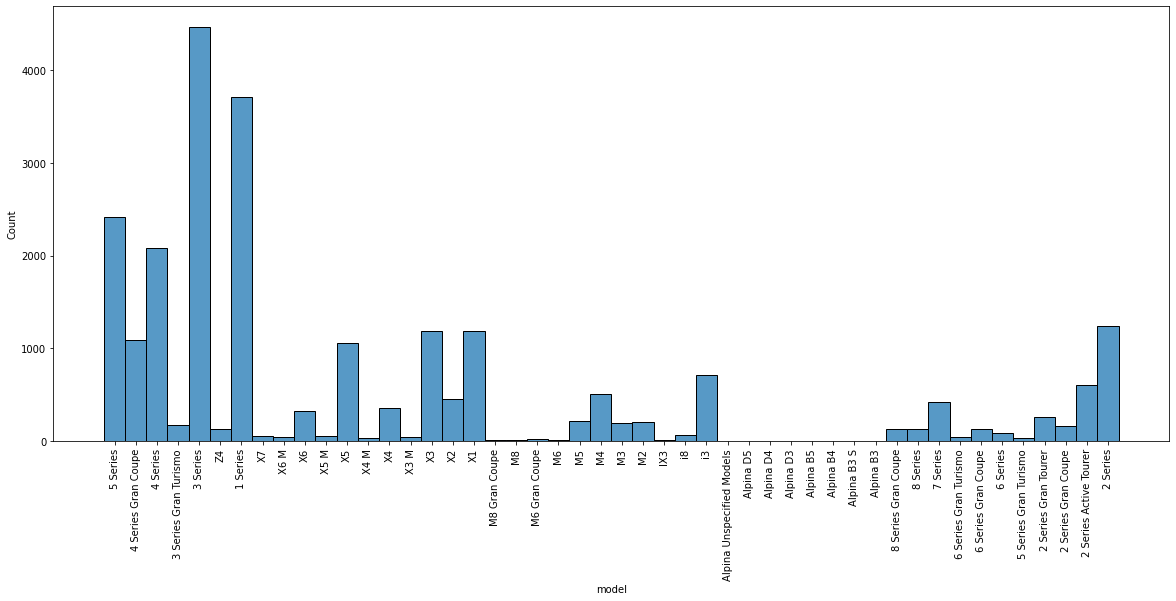

In [428]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.histplot(df['model'])

locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

I want to see if my data is suitable for a linear regression model so I will have a look at the data spread for the most influential factors as I believe them to be. I'll start off with milage.

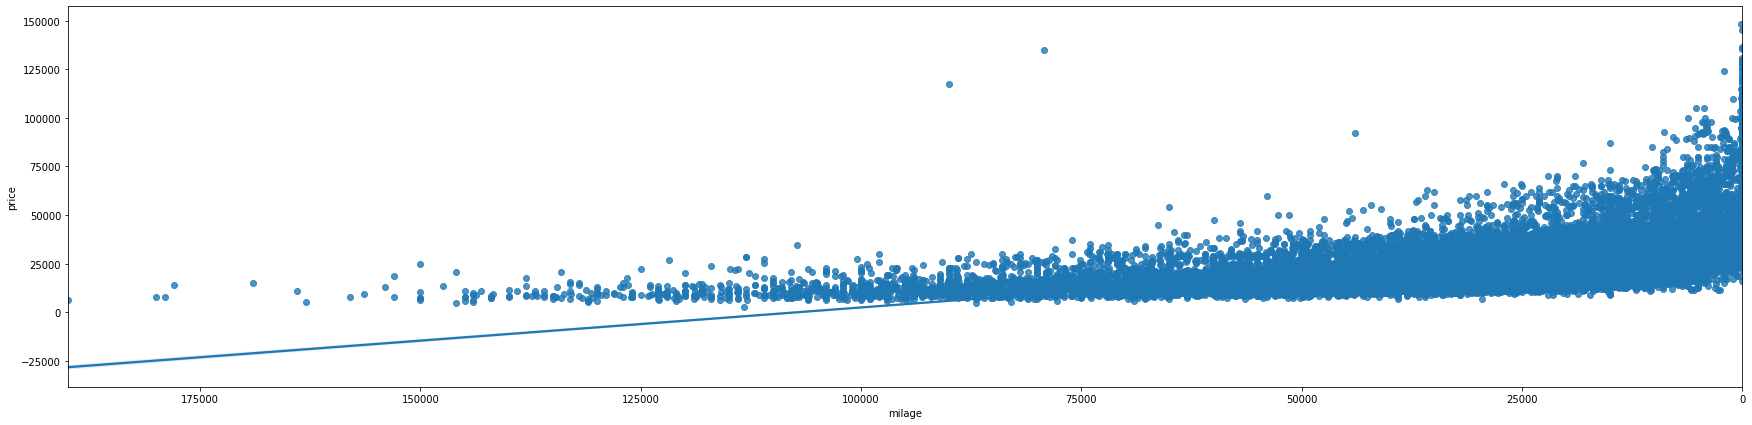

In [429]:
fig, axes = plt.subplots(1, 1, figsize=(30, 7))
plot1 = sns.regplot(x = df['milage'],\
                y = df['price'], ax = axes).invert_xaxis()

That does not look promicing. I wonder if the variation between the models is messing this up.

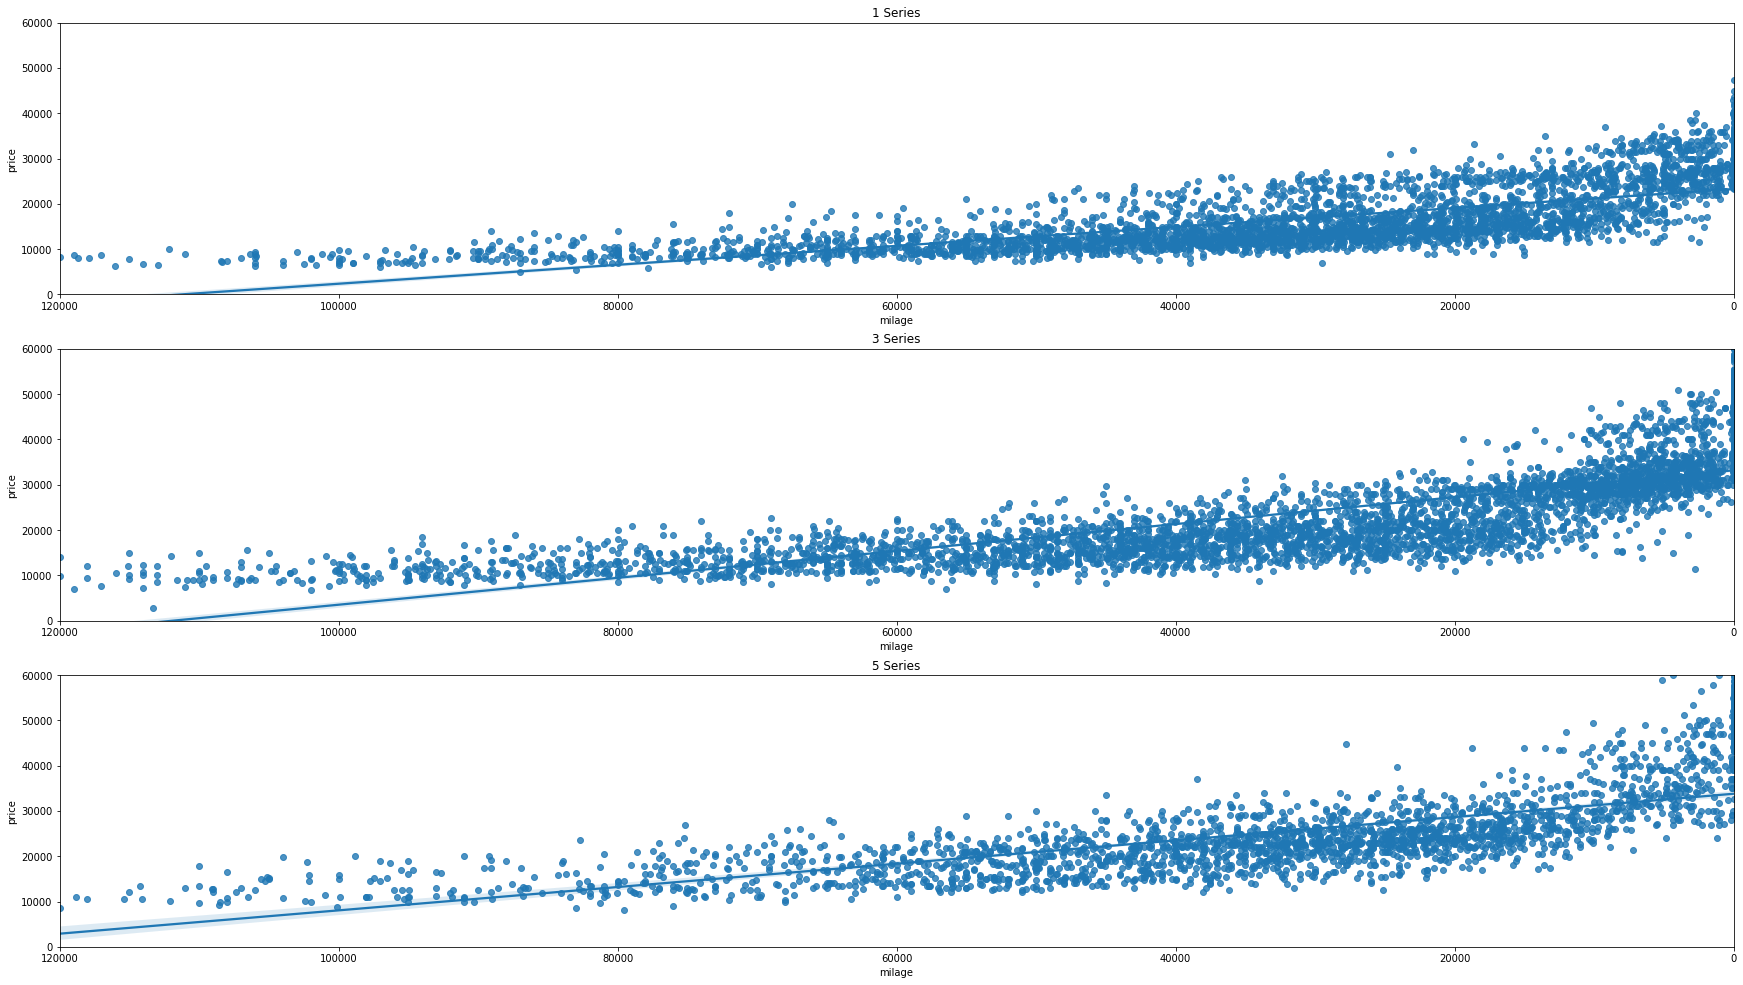

In [430]:
fig, axes = plt.subplots(3, 1, figsize=(30, 17))
plot1 = sns.regplot(x = df.loc[df['model'] == '1 Series']['milage'],\
                y = df.loc[df['model'] == '1 Series']['price'], ax = axes[0])
plot1.set(title = '1 Series')
plot2 = sns.regplot(x = df.loc[df['model'] == '3 Series']['milage'],\
                y = df.loc[df['model'] == '3 Series']['price'], ax = axes[1])
plot2.set(title = '3 Series')
plot3 = sns.regplot(x = df.loc[df['model'] == '5 Series']['milage'],\
                y = df.loc[df['model'] == '5 Series']['price'], ax = axes[2])
plot3.set(title = '5 Series')
for plot in [plot1,plot2,plot3]:
    plot.invert_xaxis()
    plot.set(xlim = (120000,0),ylim = (0,60000))

Looking at individual car models I can see an improvement but still not a very tight trend. At least the price does broadly trend up with decreasing milage.

Next let's have a look at how the data changes for the different models. For this I have calculated the mean price of all the models.

<AxesSubplot:>

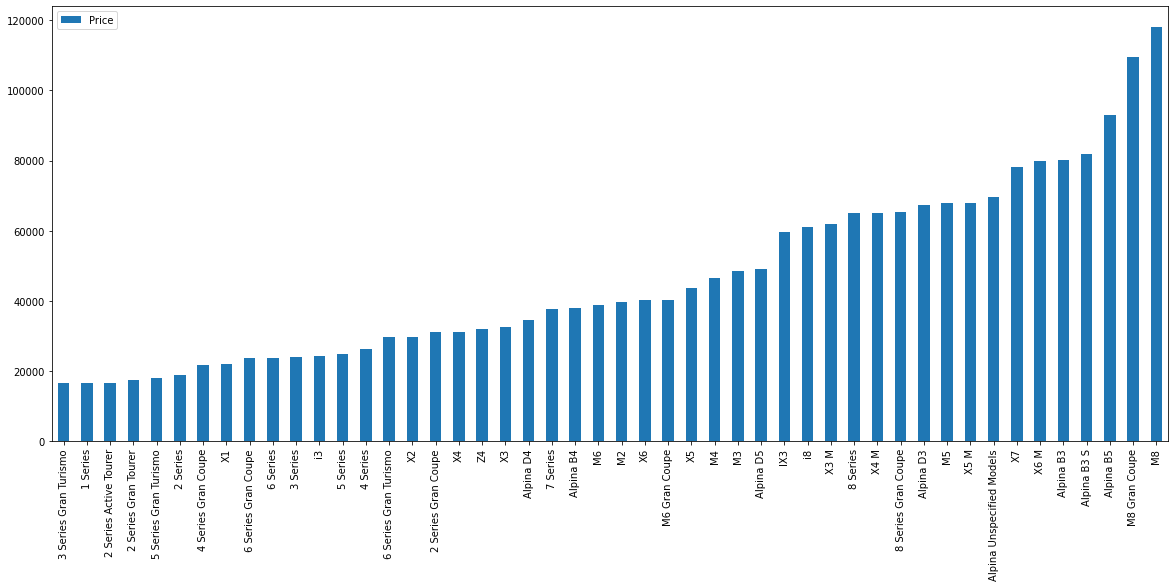

In [431]:
list_of_average_prices = []
list_of_models = []

for model in df['model'].unique():
    list_of_models.append(model)
    list_of_average_prices.append(df.loc[df['model'] == model]['price'].mean())

list_of_average_prices, list_of_models = zip(*sorted(zip(list_of_average_prices, list_of_models)))
chart_df = pd.DataFrame(data = list_of_average_prices, index = list_of_models, columns = ['Price'])
chart_df.plot.bar(figsize=(20, 8))

That is more like it. Good linear progression.

Now let's see if manufacturing year has an influence on the price.

<AxesSubplot:>

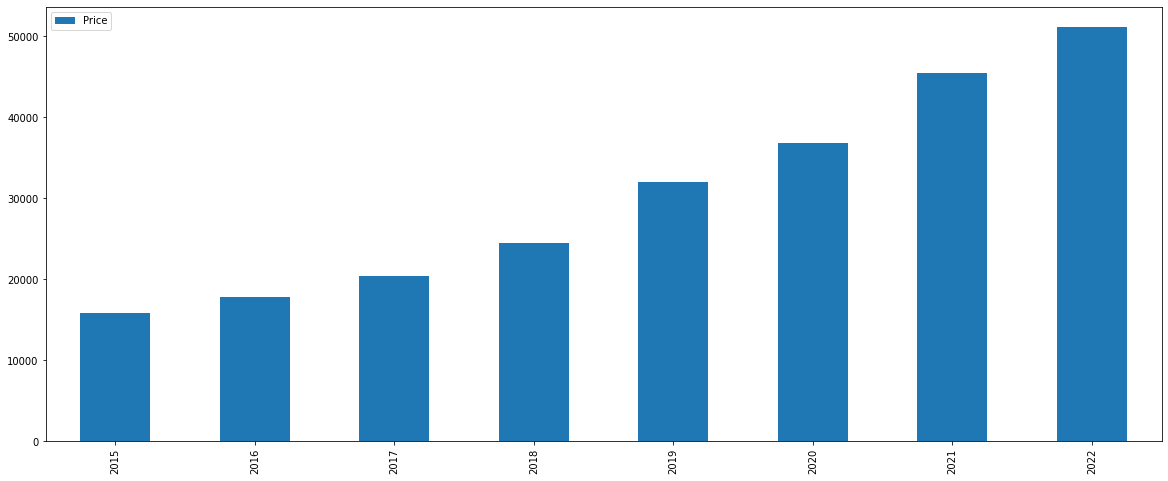

In [432]:
list_of_average_prices2 = []
list_of_years = []

for year in df['year'].unique():
    list_of_years.append(year)
    list_of_average_prices2.append(df.loc[df['year'] == year]['price'].mean())

list_of_average_prices2, list_of_years = zip(*sorted(zip(list_of_average_prices2, list_of_years)))
chart_df2 = pd.DataFrame(data = list_of_average_prices2, index = list_of_years, columns = ['Price'])
chart_df2.plot.bar(figsize=(20, 8))

In [433]:
# pd.DataFrame(df.groupby(['year']).mean()['price'])

Definite trend there for manufacturing year.

I wanted to consult another chart that takes a look at correlation to see if the milage variation is actually horrendeous. According to this chart it is not as terrible as would seem in the scatterplot.

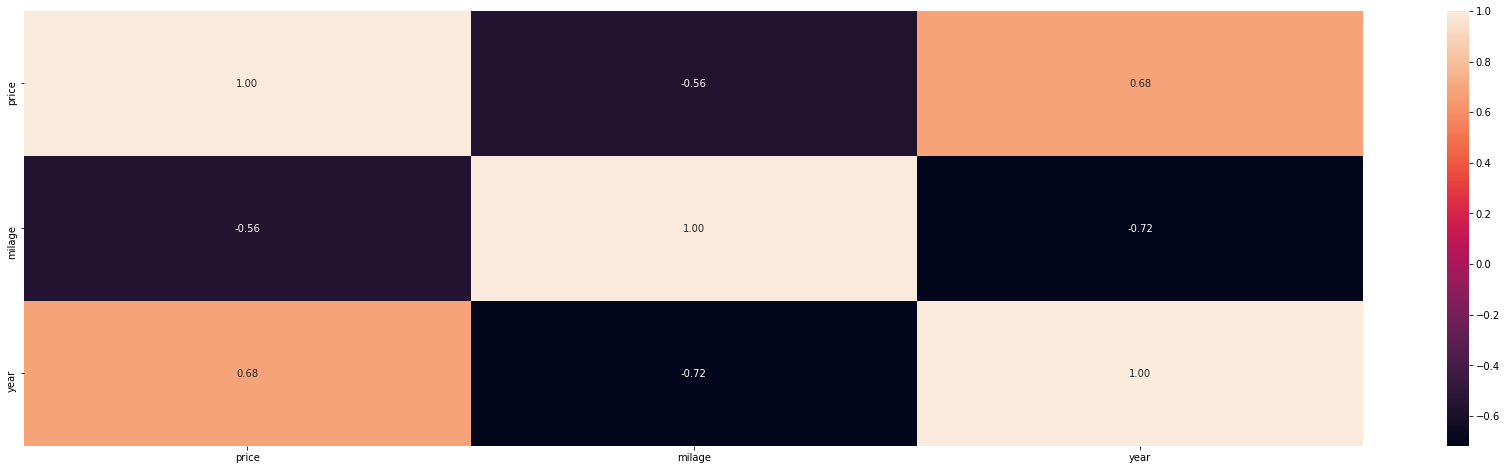

In [434]:
plt.subplots(1, 1, figsize=(30, 8))
sns.heatmap(df[['price','milage','year']].corr(), annot=True, fmt=".2f");

My assessment is that a regression model should work so let's try it out and see if we can get accurate predictions.

First up some data clean-up.

In [435]:
print('The dataframe contains a total of ', df.shape[0],' data points, out of which ', df.loc[df['service_history'] == 'unlisted'].shape[0],\
      " don't contain any data for the column service_history.\n")

# Here I am dropping columns some columns. ID is of no use to a machine learning model. Unexpected value is something that I used when
# web scraping to fault find and again is something of no use to a ML model. Lastly, service_history contains mostly NaNs, as shown above.
df_lm = df.copy().drop(['id','unexpected_value','service_history'], axis = 1)

# In hindsight I should have just had my scraper input NaNs for missing data. Will remember this for future projects.
# The below is replacing the values that I designated for no data with actual NaNs as those are easier to handle.
for idx, row in df_lm.iterrows():
    if df.loc[idx,'milage'] == 1000000:
        df.loc[idx,'milage'] = np.nan
    if df_lm.loc[idx,'body'] == 'unlisted':
        df_lm.loc[idx,'body'] = np.nan
    if df_lm.loc[idx,'engine_size'] == 50:
        df_lm.loc[idx,'engine_size'] = np.nan
    if df_lm.loc[idx,'engine_power'] == 1000000:
        df_lm.loc[idx,'engine_power'] = np.nan
    if df_lm.loc[idx,'transmission'] == 'unlisted':
        df_lm.loc[idx,'transmission'] = np.nan
    if df_lm.loc[idx,'fuel_type'] == 'unlisted':
        df_lm.loc[idx,'fuel_type'] = np.nan
    if df_lm.loc[idx,'owners'] == 100:
        df_lm.loc[idx,'owners'] = np.nan

print('Below is a status report of empty values before imputtation\n', df_lm.isnull().sum())
print('\n')

models = df_lm['model'].unique().tolist()
imputtation_list = []

# The below is grabbing the values I want to use for handling missing data for every column that I believe can have values imputted.
# The values grabbed are model specific because you can't have a 5 Series SUV, for example.
for model in models:
    temp_df = df_lm.loc[df_lm['model'] == model]
    temp_list = [temp_df['body'].mode()[0], temp_df['engine_size'].mean(), temp_df['engine_power'].mean(), temp_df['transmission'].mode()[0],\
                      temp_df['fuel_type'].mode()[0], temp_df['owners'].mean()]
    imputtation_list.append(temp_list)
    for item in temp_list:
        if pd.isna(item):
            print('The model ', model,' has no values specified for any data point for the item of index ', temp_list.index(item), ' in the temp_list variable')

for idx, row in df_lm.iterrows():
    if pd.isnull(df_lm.loc[idx,'body']):
        value_to_input = imputtation_list[models.index(df_lm.loc[idx,'model'])][0]
        df_lm.loc[idx,'body'] = value_to_input
    if pd.isnull(df_lm.loc[idx,'engine_size']):
        value_to_input = imputtation_list[models.index(df_lm.loc[idx,'model'])][1]
        df_lm.loc[idx,'engine_size'] = value_to_input
    if pd.isnull(df_lm.loc[idx,'engine_power']):
        value_to_input = imputtation_list[models.index(df_lm.loc[idx,'model'])][2]
        df_lm.loc[idx,'engine_power'] = value_to_input
    if pd.isnull(df_lm.loc[idx,'transmission']):
        value_to_input = imputtation_list[models.index(df_lm.loc[idx,'model'])][3]
        df_lm.loc[idx,'transmission'] = value_to_input
    if pd.isnull(df_lm.loc[idx,'fuel_type']):
        value_to_input = imputtation_list[models.index(df_lm.loc[idx,'model'])][4]
        df_lm.loc[idx,'fuel_type'] = value_to_input
    if pd.isnull(df_lm.loc[idx,'owners']):
        value_to_input = imputtation_list[models.index(df_lm.loc[idx,'model'])][5]
        df_lm.loc[idx,'owners'] = value_to_input

print('\n')
print('Below is a status report of empty values after imputtation\n', df_lm.isnull().sum())

# As can be seen in the output of the above print statement, for some models, there are no values present in some columns.
# This means that our loop for grabbing values to imput will use a nan as there is nothing grab.
# We can't have NaNs because the ML models can't handle them. Fortunately there is a very small number of them so we can just drop them.
df_lm = df_lm.dropna()

object_col_list = []
for col in df_lm.columns:
    if df[col].dtypes == 'object':
        object_col_list.append(col)

df_lm = pd.get_dummies(df_lm, prefix = object_col_list)

The dataframe contains a total of  24122  data points, out of which  21238  don't contain any data for the column service_history.

Below is a status report of empty values before imputtation
 price                             0
model                             0
year                              0
body                             22
milage                            0
engine_size                     787
engine_power                    361
transmission                     14
fuel_type                        10
owners                        12306
ultra_low_emissions_zone          0
first_year_road_tax               0
full_manufacturer_warranty        0
dtype: int64


The model  IX3  has no values specified for any data point for the item of index  1  in the temp_list variable
The model  Alpina Unspecified Models  has no values specified for any data point for the item of index  2  in the temp_list variable
The model  Alpina Unspecified Models  has no values specified for any data point

In [436]:
X = df_lm.copy().drop(['price'], axis = 1)
y = df_lm['price'].copy()

lm_model = LinearRegression(normalize=True) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .50, random_state=1)
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
val_mae = mean_absolute_error(y_test_preds, y_test)
r2_test = r2_score(y_test, y_test_preds)
r2_test_on_training_set = r2_score(y_train, y_train_preds)
print('R squared for the test sets is ', r2_test,'\nR squared for the train sets is ', r2_test_on_training_set)
print("Validation MAE: {:,.0f}".format(val_mae))

R squared for the test sets is  0.9165672151740624 
R squared for the train sets is  0.9048742180880087
Validation MAE: 2,978


That is pretty good correlation. Guess all the effort that went into data imputtation worked.

Let's have a look and see which features were the most important in predicting price.

In [437]:
coefs_df_lm = pd.DataFrame()
coefs_df_lm['Feature'] = X.columns
coefs_df_lm['Coefficients'] = lm_model.coef_
coefs_df_lm['Abs coefficients'] = np.abs(lm_model.coef_)
coefs_df_lm = coefs_df_lm.sort_values('Abs coefficients', ascending = False)
coefs_df_lm.head(50)

,Feature,Coefficients,Abs coefficients
47,model_X7,4.354565e+16,4.354565e+16
44,model_X5 M,4.354565e+16,4.354565e+16
46,model_X6 M,4.354565e+16,4.354565e+16
42,model_X4 M,4.354565e+16,4.354565e+16
43,model_X5,4.354565e+16,4.354565e+16
40,model_X3 M,4.354565e+16,4.354565e+16
45,model_X6,4.354565e+16,4.354565e+16
41,model_X4,4.354565e+16,4.354565e+16
39,model_X3,4.354565e+16,4.354565e+16
37,model_X1,4.354565e+16,4.354565e+16


The vehicle model is the most influential apparently.

This model only started performing well recently and before it did I build another one using another algorithm to see if I can get better predictions. Now that both are working they perform similarly. Minor advantage to the random forrest one.

In [438]:
X2 = df_lm.copy().drop(['price'], axis = 1)
y2 = df_lm['price'].copy()

lm_model2 = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1) 

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = .50, random_state=1)
lm_model2.fit(X_train2, y_train2)

y_test2_preds = lm_model2.predict(X_test2)
y_train2_preds = lm_model2.predict(X_train2)
val_mae2 = mean_absolute_error(y_test2_preds, y_test2)
r2_test = r2_score(y_test2, y_test2_preds)
r2_test_on_training_set = r2_score(y_train2, y_train2_preds)
print('R squared for the test sets is ', r2_test,'\nR squared for the train sets is ', r2_test_on_training_set)
print("Validation MAE: {:,.0f}".format(val_mae2))


R squared for the test sets is  0.9383120405505302 
R squared for the train sets is  0.9393583661883631
Validation MAE: 2,652


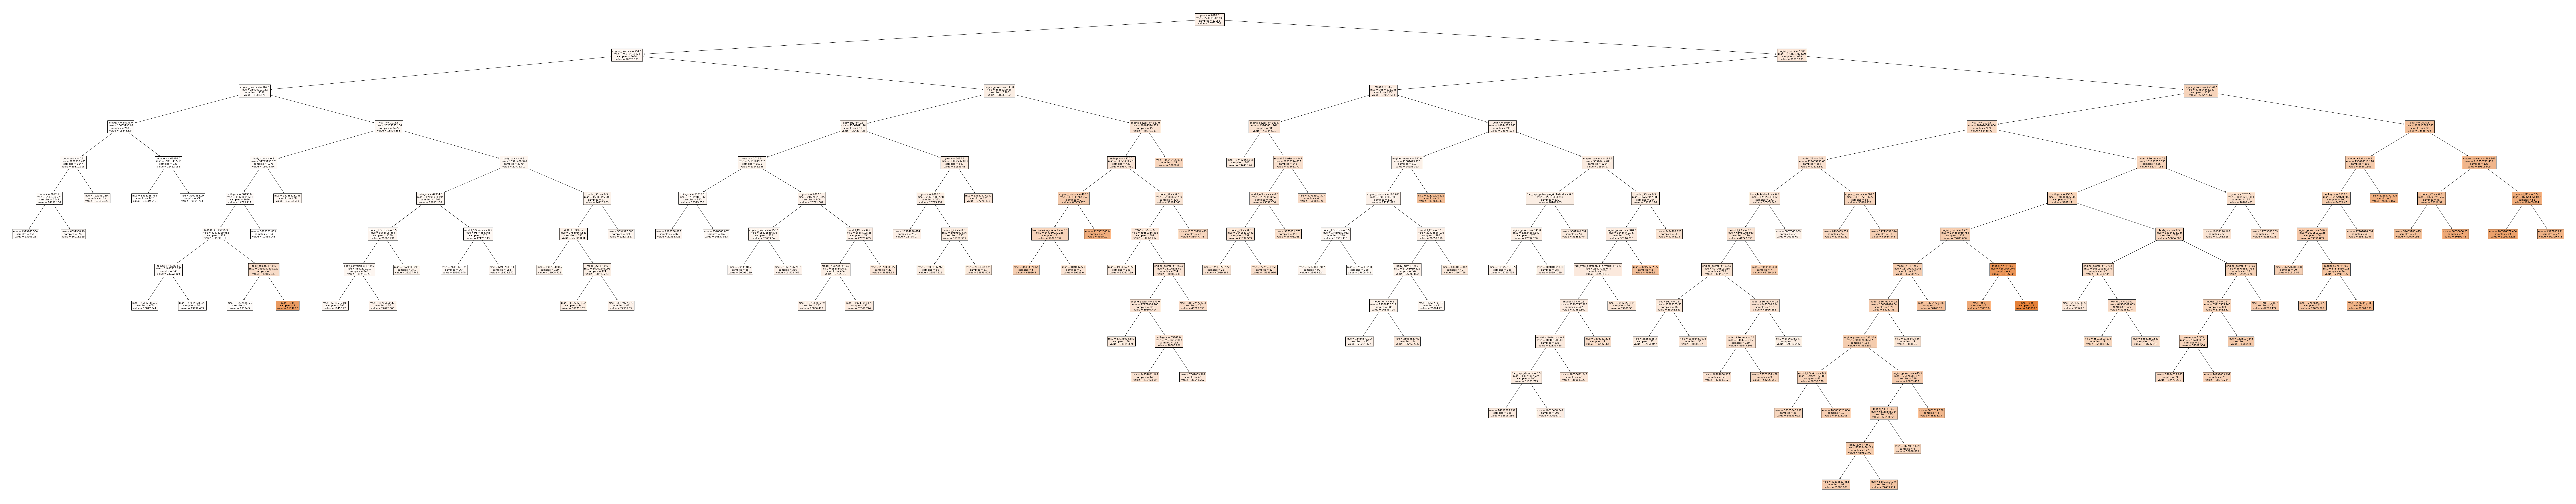

In [439]:
fig = plt.figure(figsize=(200,40))
_ = tree.plot_tree(lm_model2, 
                   feature_names= X2.columns,  
                   # class_names=iris.target_names,
                   filled=True)
# plt.savefig('test.jpg')

<BarContainer object of 67 artists>

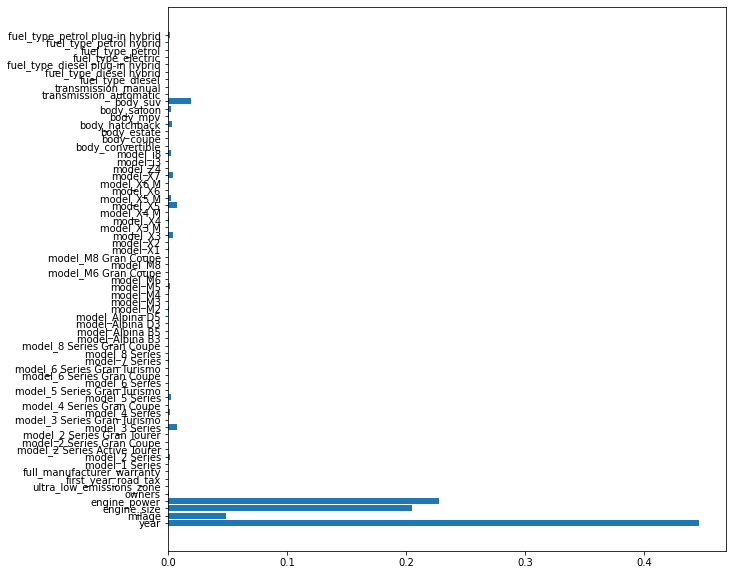

In [440]:
cols_list = X2.columns
import_list = lm_model2.feature_importances_

plt.figure(figsize=(10,10))

plt.barh(cols_list, import_list)

# print(import_list)
# import_list = zip(cols_list, import_list)
# cols_list, import_list = zip(*sorted(zip(cols_list, import_list)))
# print(import_list.)